In [1]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipywidgets import interactive, Dropdown

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_viz_df_1 = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/SDG_visualization_part_1.csv')
data_viz_df_2 = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/SDG_visualization_part_2.csv')
data_viz_df_3 = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/SDG_visualization_part_3.csv')

data_viz_df = pd.concat([data_viz_df_1, data_viz_df_2, data_viz_df_3]).reset_index(drop=True)
data_viz_df['Diagnosis (global level)'] = data_viz_df['Diagnosis (global level)'].astype('str')

In [3]:
# Restrict visualization to features and years for which we can create bins
geo_viz_df = data_viz_df[data_viz_df['Diagnosis (global level)'] != 'Cannot create bins']

In [4]:
# We need to exclude Former Sudan since we do not have information for 2021
geo_viz_df_2 = geo_viz_df[geo_viz_df['Country']!='Former Sudan']

# We need to exclude Former Sudan since we do not have information for 2021
country_year_dict = geo_viz_df_2.sort_values(['Country','Year']).drop_duplicates(subset=['Country','Year']).groupby('Country', sort=False)['Year'].apply(list).to_dict()

In [5]:
country_lst = Dropdown(options = country_year_dict.keys(), description = 'Country')
year_play_button = widgets.Play(value=2000,min=2000,max=2021,step=1,interval=700,description="Press play")

In [6]:
def sunburst_viz_3(country, year):

  output = widgets.Output(clear_output=True)

  ############ Step 1: Select the dataset for which we will create the visualization
  df_plot = geo_viz_df_2[(geo_viz_df_2['Country']==country) & (geo_viz_df_2['Year']==year)]

  ############ Step 2: Sort objects to make sure the sunburst is in the correct order
  df_plot = df_plot.sort_values(["SDG Category Nb",'Indicator', 'Unique Indicator ID'])
  
  ############ Step 3: Create a description to show using tool tips
  df_plot['Indicator Description 2'] = df_plot['Indicator Description'] + '<br>' + 'Value: ' + round(df_plot['Value'],2).astype('str')

  ############ Step 4: Make sure the labels that we want in the sunburst are all string objects
  df_plot["SDG Category Nb"] = df_plot["SDG Category Nb"].astype('str')

  ############ Step 5: Create a column to allow for plotting the "flower petals" with the same width
  df_plot['Size'] = [0.00001*i + 1 for i in range(len(df_plot))]

  ############ Step 6: Create a column with the name of the country so as to have it at the heart of the sunburst
  inner_circle_label = country + '<br>' + str(year)
  df_plot[inner_circle_label] = inner_circle_label

  ############ Step 7: Remember the colors that the UN uses for each SDG category
  list_all_colors = ['#E5243B','#DDA63A','#4C9F38','#C5192D','#FF3A21','#26BDE2','#FCC30B','#A21942','#FD6925','#DD1367','#FD9D24','#BF8B2E','#3F7E44','#0A97D9','#56C02B','#00689D','#19486A']
  SDG_list = ['1. No Poverty','2. Zero Hunger','3. Good Health and Well Being','4. Quality Education','5. Gender Equality','6. Clean Water and Sanitation','7. Affordable and Clean Energy','8. Decent Work and Economic Growth','9. Industry, Innovation and Infrastructure','10. Reduced Inequalities','11. Sustainable Cities and Communities','12. Responsible Consumption and Production','13. Climate Action','14. Life Below Water','15. Life on Land','16. Peace, Justice and Strong Institutions','17. Partnerships for the Goals']
  color_dict_ori  = dict(zip(SDG_list, list_all_colors))

  ############ Step 8: Encode the SDGs as letters rather than numbers to prevent sunburst malfuncioning (it automatically sorts SGDs as 1, 10, 11 .... since they are string values)
  letter_order_dict  = dict(zip(SDG_list, ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q']))
  df_plot['SDG Category Letters'] = df_plot['SDG Cat. Description'].map(letter_order_dict)

  ############ Step 9: Map colors for each one of the SDG categories in the plot
  df_plot['sunburst_color'] = df_plot['SDG Cat. Description'].map(color_dict_ori)

  ############ Step 10: Create dictionarioes for each one of the layers of the sunburst and then merge these dictionaries
  
  # 10.0) Create a dictionary with the first item as the country which is the label for the inner circle
  color_dict = {inner_circle_label:'#FFFFFF'}
  
  # 10.1) Create the first dictionary for the first layers of the sunburst (Number of the SDG)
  color_dict_1  = df_plot.drop_duplicates("SDG Category Letters").set_index('SDG Category Letters')['sunburst_color'].to_dict()

  # 10.2) Create the second dictionary that refers to the second layer (Indicators such as 1.1.1)
  color_dict_2 = df_plot.drop_duplicates("Indicator").set_index('Indicator')['sunburst_color'].to_dict()

  # 10.3) Create the third dictionary that refers to the third layer (Indicators such as 1.1.1.1)
  color_dict_3 = dict(zip(df_plot['Unique Indicator ID'].tolist(), df_plot['color'].tolist()))

  # 10.4) Add all keys and values from all the dictionaries
  color_dict.update(color_dict_1)
  color_dict.update(color_dict_2)
  color_dict.update(color_dict_3)

  ############ Step 11: Now we create a dictionary that will later be used to replace the letter A,B,C ... by 1,2,3 ....
  new_labels = [inner_circle_label] + df_plot.drop_duplicates("SDG Category Nb")['SDG Category Nb'].tolist() + list(color_dict_2.keys()) + list(color_dict_3.keys())
  old_labels = list(color_dict.keys())
  label_dict = dict(zip(old_labels, new_labels))

  ############ Step 12: Create the visualization
  fig = px.sunburst(df_plot, path=[inner_circle_label,"SDG Category Letters",'Indicator', 'Unique Indicator ID'], values='Size', 
                    width=700, height=700, hover_name = 'Indicator Description 2', hover_data = {'Size':False,'SDG Cat. Description':True})
  
  fig.update_traces(sort=False, marker_colors=[color_dict[cat] for cat in fig.data[-1].labels]) # Map color for each part of the sunburst
  #fig.update_layout(title_text= country + "'s Sustainability Sunburst (" + str(year) + ')', title_x=0.5,
                    font=dict(family="Courier New, monospace", size=22, color="RebeccaPurple" ))
  
  fig.update_traces(labels= [label_dict [cat] for cat in fig.data[-1].labels])   # Replace A,B,C labels by 1,2,3
  fig.update_layout(showlegend=True)
  return fig.show()

In [7]:
display(interactive(sunburst_viz_3, country = country_lst, year = year_play_button))

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

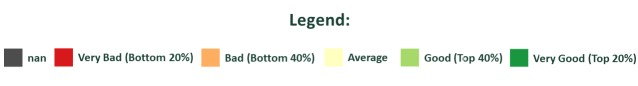

In [8]:
Image('https://raw.githubusercontent.com/leonardodecastro/data/main/image_legend.jpg')